In [1]:
import torchaudio
import torchaudio.functional as F_audio
import torchaudio.transforms as T_audio

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
from torchdata.datapipes.iter import FileOpener, HttpReader, IterableWrapper
from torch.utils.data import DataLoader
import functools
import os
import librosa
import numpy as np

import warnings
import glob
import io
from joblib import delayed 
import fma.utils as fma

from cacher import root, file_cached, mem_cached, clear_cache
from utils import ProgressParallel, plot_waveform, plot_spectrogram, plot_fbank, plot_mel_fbank
from data_loader import read_wavs

from IPython.display import Audio, display

from spectrogrammer import Spectrogramer
import matplotlib.pyplot as plt

SAMPLE_RATE = 4096
LENGTH_SECONDS = 1.0
LENGTH = int(round((LENGTH_SECONDS * SAMPLE_RATE)))
wavs = read_wavs("small", SAMPLE_RATE, LENGTH_SECONDS, LENGTH)
wavs = Tensor(wavs)
print("wavs.shape=", wavs.shape)

N_FFT = 1024
WIN_LENGTH = None
HOP_LENGTH = 512
N_MELS = 128
spectrogrammer = Spectrogramer(sample_rate = SAMPLE_RATE,
              n_fft = N_FFT,
              win_length = WIN_LENGTH,
              hop_length = HOP_LENGTH,
              n_mels = N_MELS)
x = spectrogrammer.wave2mel(wavs)
print("x (spectrogram of wavs).shape=", x.shape)

wavs.shape= torch.Size([7996, 4096])
x (spectrogram of wavs).shape= torch.Size([7996, 128, 9])


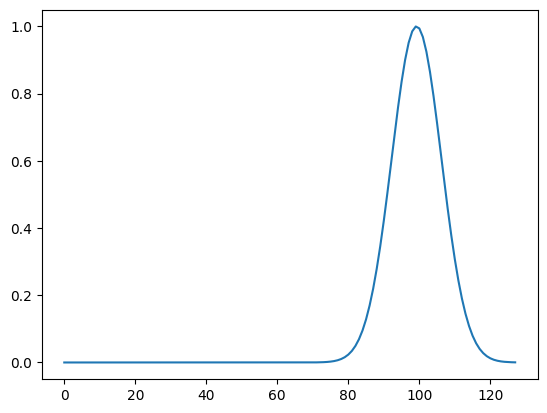

In [10]:
def nd_based_filter(N, centers):
    cnt = centers.shape[0]
    x = torch.linspace(0, N, N, device=centers.device).repeat(cnt, 1)
    centers = centers.repeat(N, 1).T
    d = 10
    return torch.e ** (-((x - centers) / d) ** 2)

plt.plot(nd_based_filter(N_MELS, torch.Tensor([10, 50, 100]))[2])

In [186]:
# nn.Tanhshrink(),
# nn.Sigmoid(),
# nn.ReLU(),

def apply_filters(x, filters, idxs):
    idxs = idxs.view(-1).long() # (N), long
    vec = filters[idxs] # (N, )
    return x * vec[:, None, :, None]

class Generator(nn.Module):
    def __init__(self, max_val):
        super().__init__()

        self.main = nn.Sequential( # 1, 128, 9
            nn.Conv2d(1, 4, kernel_size=3, padding="same"),  # 4, 128, 9
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(4, 1)),  # 4, 32, 9

            nn.Conv2d(4, 4, kernel_size=(4, 3), padding="same"), # 4, 32, 9
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(4, 1)),  # 4, 8, 9

            nn.Conv2d(4, 4, kernel_size=(4, 3), padding="same"), # 4, 8, 9
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=(2, 1)),  # 4, 4, 9
            
            nn.Flatten(),
            nn.Linear(4 * 4 * 9, 1),
            nn.Softmax(),
        )
        self.max_val = max_val

    def forward(self, x):
        idxs = self.main(x / self.max_val) # (N, 1)
        return apply_filters(x, up_filters_gpu, idxs)

    # def forward(self, x):
    #     x = x / self.max_val
    #     vec = self.main(x)
    #     # print(x.shape) # (N, 1, 128, 9)
    #     # print(vec.shape) # (N, 128)
    #     # print(vec[:, None, :, None].shape) # (N, 1, 128, 1)
    #     return x * vec[:, None, :, None] #self.eq(x, vec)

class Discriminator(nn.Module):
    def __init__(self, max_val):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential( # 1, 128, 9
            nn.Conv2d(1, 4, kernel_size=3, padding="same"),  # 4, 128, 9
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(4, 1)),  # 4, 32, 9

            nn.Conv2d(4, 4, kernel_size=(4, 3), padding="same"), # 4, 32, 9
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(4, 1)),  # 4, 8, 9

            nn.Conv2d(4, 4, kernel_size=(4, 3), padding="same"), # 4, 8, 9
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1)),  # 4, 4, 9
            
            nn.Flatten(),
            nn.Linear(4 * 4 * 9, 1),
            nn.Sigmoid(),
        )
        self.max_val = max_val
    def forward(self, x):
        return self.main(x / self.max_val)

cuda = torch.device('cuda:0')

x_gpu = x.to(cuda)
x_gpu = torch.unsqueeze(x_gpu, 1)

up_filters_gpu = up_filters.to(cuda)
down_filters_gpu = down_filters.to(cuda)

max_val = x_gpu.max().item()
modelG = Generator(max_val).to(cuda)
modelD = Discriminator(max_val).to(cuda)


def get_noised(x, filters):
    idxs = torch.randint(filters.shape[0], (x.shape[0], ), device=cuda)
    return apply_filters(x, filters, idxs)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(modelD.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(modelG.parameters(), lr=3e-4, betas=(0.5, 0.999))
                            #  weight_decay = 1e-8)
# schedulerD = ReduceLROnPlateau(optimizerD, factor=0.9, threshold=1e-4, patience=10)
# schedulerG = ReduceLROnPlateau(optimizerG, factor=0.9, threshold=1e-4, patience=10)

REAL = 1.
FAKE = 0.
N = x.shape[0]
LABEL_REAL = torch.full((N,), REAL, dtype=torch.float, device=cuda)
LABEL_FAKE = torch.full((N,), FAKE, dtype=torch.float, device=cuda)


epochs = 10000
outputs = []
G_losses = []
D_losses = []
for epoch in range(epochs):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    modelD.zero_grad()
    output = modelD(x_gpu).view(-1)
    errD_real = criterion(output, LABEL_REAL)
    errD_real.backward()
    D_x = output.mean().item()

    noised = get_noised(x_gpu, down_filters_gpu)
    fake = modelG(noised)
    output = modelD(fake.detach()).view(-1)
    errD_fake = criterion(output, LABEL_FAKE)
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    modelG.zero_grad()
    output = modelD(fake).view(-1)
    errG = criterion(output, LABEL_REAL)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    # schedulerD.step(errD)
    # schedulerG.step(errG)
    
    lrD = optimizerD.param_groups[0]['lr']
    lrG = optimizerG.param_groups[0]['lr']
    if True: # i % 50 == 0:
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f  lr_D: %.4f lr_G: %.4f'
                % (epoch, epochs,
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, lrD, lrG))

    G_losses.append(errG.item())
    D_losses.append(errD.item())

    if lrG < 1e-5 or lrD < 1e-5:
        print("break at", epoch)
        break
    # audio = spectrogrammer.mel2wave(model(x[0:1]))
    # Audio(audio.numpy(), sample_rate=SAMPLE_RATE)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(G_losses[100:], label="G_loss")
plt.plot(D_losses[100:], label="D_loss")
plt.legend()
# Plotting the last 100 values

/home/misha-sh/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/10000]	Loss_D: 1.3864	Loss_G: 0.6887	D(x): 0.5041	D(G(z)): 0.5041 / 0.5022  lr_D: 0.0010 lr_G: 0.0003
[1/10000]	Loss_D: 1.3863	Loss_G: 0.6921	D(x): 0.5022	D(G(z)): 0.5022 / 0.5005  lr_D: 0.0010 lr_G: 0.0003
[2/10000]	Loss_D: 1.3863	Loss_G: 0.6943	D(x): 0.5005	D(G(z)): 0.5005 / 0.4994  lr_D: 0.0010 lr_G: 0.0003
[3/10000]	Loss_D: 1.3863	Loss_G: 0.6947	D(x): 0.4994	D(G(z)): 0.4994 / 0.4992  lr_D: 0.0010 lr_G: 0.0003
[4/10000]	Loss_D: 1.3863	Loss_G: 0.6941	D(x): 0.4992	D(G(z)): 0.4992 / 0.4995  lr_D: 0.0010 lr_G: 0.0003
[5/10000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.4995	D(G(z)): 0.4995 / 0.5000  lr_D: 0.0010 lr_G: 0.0003
[6/10000]	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5000	D(G(z)): 0.5000 / 0.5003  lr_D: 0.0010 lr_G: 0.0003
[7/10000]	Loss_D: 1.3863	Loss_G: 0.6926	D(x): 0.5003	D(G(z)): 0.5003 / 0.5003  lr_D: 0.0010 lr_G: 0.0003
[8/10000]	Loss_D: 1.3863	Loss_G: 0.6930	D(x): 0.5003	D(G(z)): 0.5003 / 0.5001  lr_D: 0.0010 lr_G: 0.0003
[9/10000]	Loss_D: 1.3863	Loss_G: 0.6932	D(x): 0.5001	D(

KeyboardInterrupt: 

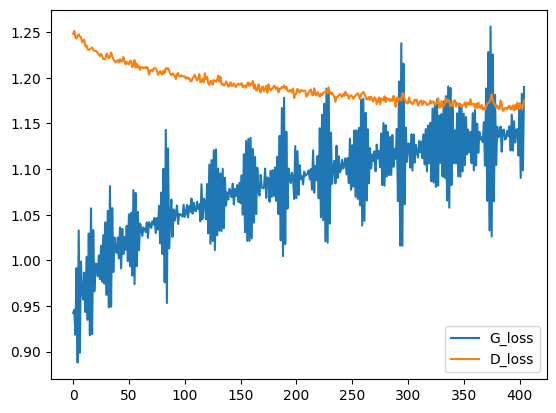

In [187]:

plt.plot(G_losses[100:], label="G_loss")
plt.plot(D_losses[100:], label="D_loss")
plt.legend()

torch.Size([7996, 1, 128, 9])

In [138]:
x_gpu = x.to(cuda)
a = 0
x_initial_gpu = x_gpu[a:a + 1,].unsqueeze(1)
noised = get_noised(x_initial_gpu) #, down_filters_gpu)

with torch.no_grad():
    cleaned = trainer.model(noised)

orig_wave = spectrogrammer.mel2wave_with_phase(x_initial_gpu[0].cpu(), wavs[a])
noised_wave = spectrogrammer.mel2wave_with_phase(noised[0].cpu(), wavs[a])
cleaned_wave = spectrogrammer.mel2wave_with_phase(cleaned[0].cpu(), wavs[a])

display(Audio(orig_wave.numpy(), rate=SAMPLE_RATE))
display(Audio(noised_wave.numpy(), rate=SAMPLE_RATE))
display(Audio(cleaned_wave.numpy(), rate=SAMPLE_RATE))
plt.imshow((x_initial_gpu[0][0] - cleaned[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")
plt.show()
plt.imshow((noised[0][0] - cleaned[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")
plt.show()
plt.imshow((x_initial_gpu[0][0] - noised[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 360])

In [51]:
(x_initial_gpu[0][0] - noised[0][0]).cpu()[:,4]

tensor([ 0.0000,  0.0802,  0.1829,  0.2715,  0.0879, -0.1447, -0.1163, -0.2758,
        -0.0214, -0.5481, -1.2333, -0.4696, -1.1906, -1.4247, -0.0823, -0.5343,
        -1.6881, -1.1896, -0.2284, -0.0524, -0.5607, -0.7738, -0.1667, -0.1973,
        -0.4599, -0.1297, -0.2605, -0.1820,  0.0467, -0.3178, -0.9913, -2.1537,
        -0.8566, -0.2070, -0.0079, -0.4611, -0.6330, -1.3257, -1.3615, -1.1484,
        -0.8437, -0.4064, -0.2675, -0.1034,  0.0350,  0.1220,  0.1550, -0.2539,
        -0.1308,  0.1587, -0.0251,  0.0796,  0.0835, -0.2039, -0.6141, -2.7139,
        -2.7680, -1.0132, -0.2252,  0.0751,  0.1064,  0.0070, -0.5191, -0.9130,
        -1.3855, -1.3584, -0.5614, -0.0380,  0.1561,  0.0743, -0.0555, -0.1317,
        -0.1955, -0.3901, -0.9063, -0.3525,  0.2324,  0.2656,  0.2165, -0.3530,
        -0.3148, -0.0851, -0.0374, -0.0945,  0.0685, -0.0764, -0.3830, -0.2706,
        -0.1789, -0.3254, -0.3080, -0.0289,  0.2330,  0.2812,  0.3106,  0.2675,
         0.0891,  0.0992,  0.1305,  0.00

In [140]:
noised.shape

torch.Size([1, 1, 128, 9])

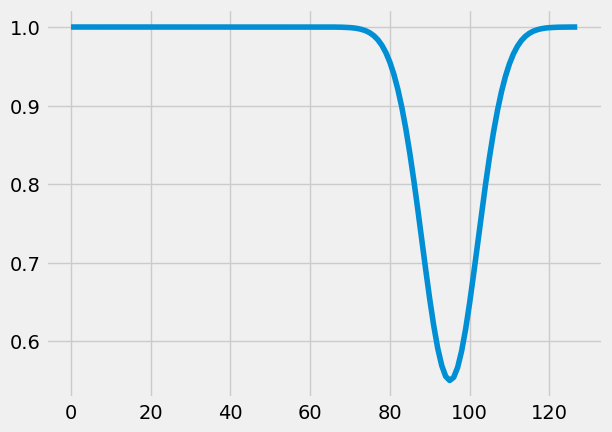

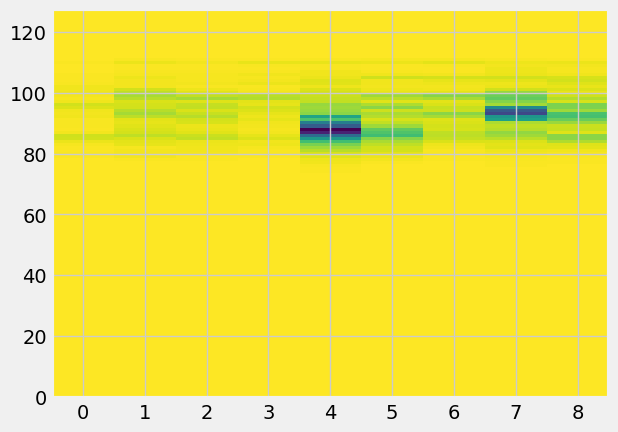

In [79]:
# centers = torch.rand((x.shape[0], ), device=x.device)
# centers = remap(centers, 0, 1, 32, N_MELS - 32)
filters = nd_based_filter(N_MELS, centers) # (N, N_MELS)
down_filters = 1 - 0.45 * filters
# return x * down_filters[:, None, :, None]
plt.plot(down_filters[0])
plt.show()

xx = x.unsqueeze(1)
noised = xx * down_filters[:, None, :, None]
plt.imshow(noised[0][0] - xx[0][0], origin="lower", aspect="auto")

In [74]:
x.unsqueeze(1).shape

torch.Size([7996, 128, 9])

In [65]:
down_filters[:, None, :, None]

tensor([[[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [0.9999],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        ...,


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]]])

In [136]:
# nn.Tanhshrink(),
# nn.Sigmoid(),
# nn.ReLU(),

import importlib
import trainer_mod
import tuner

importlib.reload(trainer_mod)
importlib.reload(tuner)
Trainer = trainer_mod.Trainer

def remap(val, old_0, old_1, new_0, new_1):
    return (val - old_0) / (old_1 - old_0) * (new_1 - new_0) + new_0

def suggest_activation(name, trial):
    cat = trial.suggest_categorical(name, ["tanh", "relu", "leakyrelu", "sigmoid"])
    if cat == "tanh":
        return nn.Tanh()
    elif cat == "relu":
        return nn.ReLU(True)
    elif cat == "leakyrelu":
        return nn.LeakyReLU(trial.suggest_float("leakyrelu",0.01, 0.01, 0.1, log=True))
    elif cat == "sigmoid":
        return nn.Sigmoid() 

class Generator(nn.Module):
    def __init__(self, max_val, trial):
        super().__init__()

        mk = trial.suggest_int("mid_kernels", 2, 2, 10)
        batch_normalization = nn.BatchNorm2d(mk) if trial.suggest_int("batchnorm", 1, 0, 1) == 1 else nn.Identity()
        
        self.main = nn.Sequential( # 1, 128, 9
            nn.Conv2d(1, mk, kernel_size=8, padding="same"),  # mk, 128, 9
            batch_normalization,
            suggest_activation("act1", trial),
            nn.MaxPool2d(kernel_size=(4, 1)),  # mk, 32, 9

            nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 32, 9
            batch_normalization,
            suggest_activation("act2", trial),
            nn.MaxPool2d(kernel_size=(4, 1)),  # mk, 8, 9

            nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 8, 9
            batch_normalization,
            suggest_activation("act3", trial),
            nn.MaxPool2d(kernel_size=(2, 1)),  # mk, 4, 9
            
            nn.Flatten(),
            # nn.Linear(mk * 4 * 9, 1),
            nn.Linear(mk * 4 * 9, mk * 4 * 9),
            nn.BatchNorm1d(mk * 4 * 9),
            nn.Tanh(),
            nn.Linear(mk * 4 * 9, 1),
            nn.Sigmoid(),
        )
        self.filter_coef = nn.Parameter(torch.tensor(0.3))
        self.max_val = max_val

    def forward(self, x):
        centers = self.main(x / self.max_val).view(-1) # (N, )
        centers = remap(centers, 0, 1, 32, N_MELS - 32)
        filters = nd_based_filter(N_MELS, centers) # (N, N_MELS)
        up_filters = 1 + self.filter_coef * filters
        # for i in filters.detach().cpu().numpy():
        #     plt.plot(i)
        # plt.show()
        return x * up_filters[:, None, :, None]

def get_noised(x):
    if len(x.shape) != 4:
        raise Exception("Invalid shape")
    centers = torch.rand((x.shape[0], ), device=x.device)
    centers = remap(centers, 0, 1, 32, N_MELS - 32)
    filters = nd_based_filter(N_MELS, centers) # (N, N_MELS)
    down_filters = 1 - 0.45 * filters
    return x * down_filters[:, None, :, None]

def accurancy(trainer):
    real = trainer.x_test
    noised = get_noised(real)
    with torch.no_grad():
        predicted = trainer.model(noised)

    noise_amount = (real - noised).abs().mean().item()
    predicted_noise_amount = (real - predicted).abs().mean().item()

    return {
        "fix_percent": predicted_noise_amount / noise_amount,
        "noise": noise_amount,
        "predicted_noise": predicted_noise_amount,
    }

def create_trainer(trial):
    max_val = x.max().item()
    modelG = Generator(max_val, trial)

    optimizer = torch.optim.Adam(modelG.parameters(), 
                            lr=trial.suggest_float("lr", 7e-2, 1e-3, 1e-1, log=True), 
                            betas=(0.5, 0.999))
    trainer = Trainer(model=modelG, 
                    loss=nn.MSELoss(),
                    optimizer=optimizer,
                    scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        "fix_accurancy": accurancy,
                    })

    x_prepared = torch.unsqueeze(x, 1)
    trainer.set_data(x_prepared)

    trainer.data_lambda = get_noised
    trainer.early_stop_lambda = lambda trainer: trainer.get_lr() < 1e-5
    return trainer


def objective(trial):
    trainer = create_trainer(trial)
    trainer.train(400, trial=trial, log=False)
    # trainer.plot_history(100)

    return trainer.history['test_loss'][-1]

print("separtate banch normalization")
# cuda = torch.device('cuda:0')
# tuned_params = tuner.tune(objective, n_trials=1000, timeout=600)
# tuned_params

separtate banch normalization


In [121]:
trainer.model.filter_coef

Parameter containing:
tensor(0.3701, device='cuda:0', requires_grad=True)

[0/1000]	 loss: 0.0096 loss_test: 0.0097  lr: 0.0026  fix_percent: 1.1400 noise: 0.0228 predicted_noise: 0.0260 
[1/1000]	 loss: 0.0096 loss_test: 0.0117  lr: 0.0026  fix_percent: 1.2884 noise: 0.0228 predicted_noise: 0.0294 
[2/1000]	 loss: 0.0114 loss_test: 0.0091  lr: 0.0026  fix_percent: 1.0785 noise: 0.0227 predicted_noise: 0.0245 
[3/1000]	 loss: 0.0092 loss_test: 0.0099  lr: 0.0026  fix_percent: 1.1451 noise: 0.0224 predicted_noise: 0.0257 
[4/1000]	 loss: 0.0098 loss_test: 0.0093  lr: 0.0026  fix_percent: 1.0687 noise: 0.0227 predicted_noise: 0.0242 
[5/1000]	 loss: 0.0094 loss_test: 0.0090  lr: 0.0026  fix_percent: 1.1026 noise: 0.0230 predicted_noise: 0.0253 
[6/1000]	 loss: 0.0093 loss_test: 0.0088  lr: 0.0026  fix_percent: 1.0522 noise: 0.0225 predicted_noise: 0.0237 
[7/1000]	 loss: 0.0093 loss_test: 0.0087  lr: 0.0026  fix_percent: 1.0373 noise: 0.0229 predicted_noise: 0.0237 
[8/1000]	 loss: 0.0085 loss_test: 0.0088  lr: 0.0026  fix_percent: 1.0303 noise: 0.0228 predicte

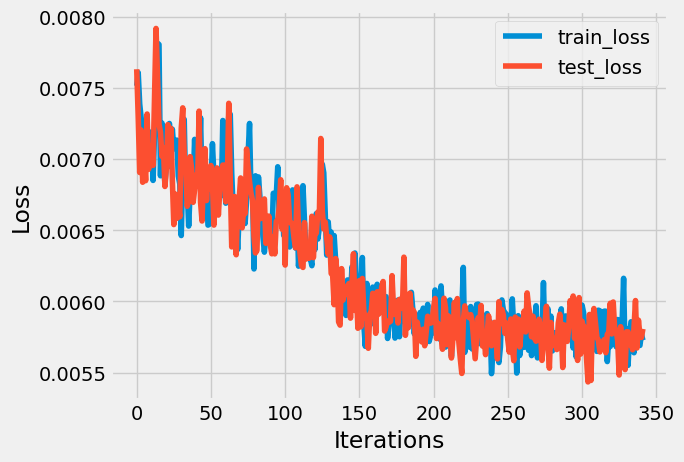

In [137]:
trial = tuned_params
trainer = create_trainer(trial) 
# trainer.scheduler=ReduceLROnPlateau(optimizerG, factor=0.2, threshold=1e-2, patience=50))

trainer.train(1000, trial=trial, log=True)

trainer.plot_history(100)

In [221]:
tuned_params.suggest_int("batchnorm", 1, 0, 1)

1

In [37]:
with torch.no_grad():
    x_pred = model(x_gpu)
x_pred = torch.squeeze(x_pred, dim=1)
print(x_pred.shape)
wave_pred = spectrogrammer.mel2wave_with_phase(x_pred[0], wavs[0])
display(Audio(wave_pred.cpu().numpy(), rate=SAMPLE_RATE))

torch.Size([100, 128, 9])


In [45]:
Audio(wavs[0].cpu().numpy() - wave_pred.cpu().numpy(), rate=SAMPLE_RATE)

In [51]:
plot_spectrogram(x_pred[0].cpu().numpy())

NameError: name 'x_pred' is not defined

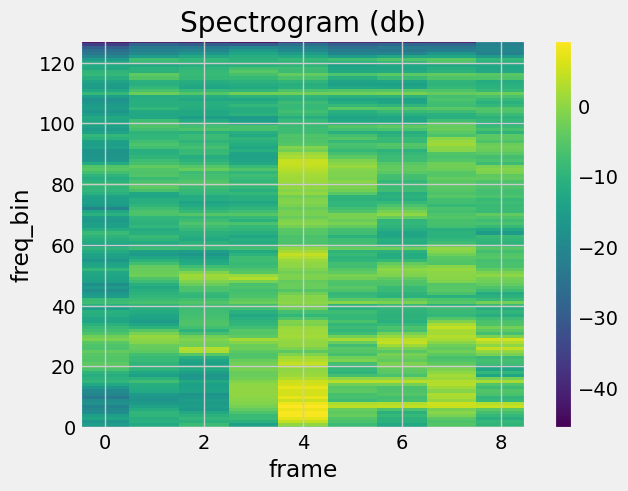

In [39]:
plot_spectrogram(x[0].cpu().numpy())

In [46]:
display(Audio(wavs[0], rate=SAMPLE_RATE))
wave = spectrogrammer.mel2wave(x[0])
display(Audio(wave.numpy(), rate=SAMPLE_RATE))

In [150]:
model = model_gpu.to("cpu")
x_pred = model(x)
wave_pred = spectrogrammer.mel2wave(x_pred)
wave_pred.shape

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [154]:
spectrogrammer.mel2wave(x).shape

KeyboardInterrupt: 

In [91]:
tensor

tensor([[-0.2018,  0.0599],
        [ 0.2664,  1.5481]])

In [55]:
torch.__version__

'1.12.1+cu116'

In [ ]:
for epoch in range(epochs):
    for i in x:
       
    #   # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)
       
      # Output of Autoencoder
      reconstructed = model(x)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, x)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
      print(loss)
    outputs.append((epochs, image, reconstructed))